# Explore foveated sampling from images

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import torch    
import itertools

device = 'cpu'


## 1. visualize sampling grids from different retinal sensors
- **isotropic**: a locally isotropic version of the log-polar image model, and very similar to the conformal map (which preserves local isotropy in a continuous representation) but with better discrete behavior at small radii and near the vertical meridians, particularly at lower sampling resolutions. sampling is first done evenly in $w=\log(r+a)$, and then at each value $w_i$, sampling of $r$ is done so as to guarantee local isotropy. formally:  $D((w_i,r_j), (w_{i+1}, r_j) = D((w_{i+1}, r_{j}), (w_{i+1},r_{j+1}) = m_\theta = m_r$, where $m_\theta$ and $m_r$ are the angular and radial resolutions. The number of angles to sample at each radius is then computed as $n_{\theta,{i+1}}=\frac{2\pi}{m_\theta}$.

- **log-polar image**: given $w=\log(r+a)$, $\theta$. cortical space is x'=$w$, y'=$\theta$. sampling is done evenly in cortical $x'$ and $y'$ to produce a rectangular image. this introduces strong local anisotropies that are heavily dependent on eccentricity. 

- **uniform**: standard, uniform sampling done on a regular grid in image space

We store four coordinate frames for each sampling grid:
- **cortical**: the sensor manifold
- **plotting**: a 2-D visualization of the sensor manifold. 
- **cartesian**: normalized X,Y coordinates in image space
- **image**: normalized row, col coordinates in image space (-Y, X)

Below, we plot the **plotting** and **cartesian** coordinates. 

These are generally the easiest to work with for 2D scatter plots, because we can set `x=coords.this_frame[:,0]` and `y=coords.this_frame[:,1]` without much thought.



In [2]:
from fovi.sensing.coords import SamplingCoords

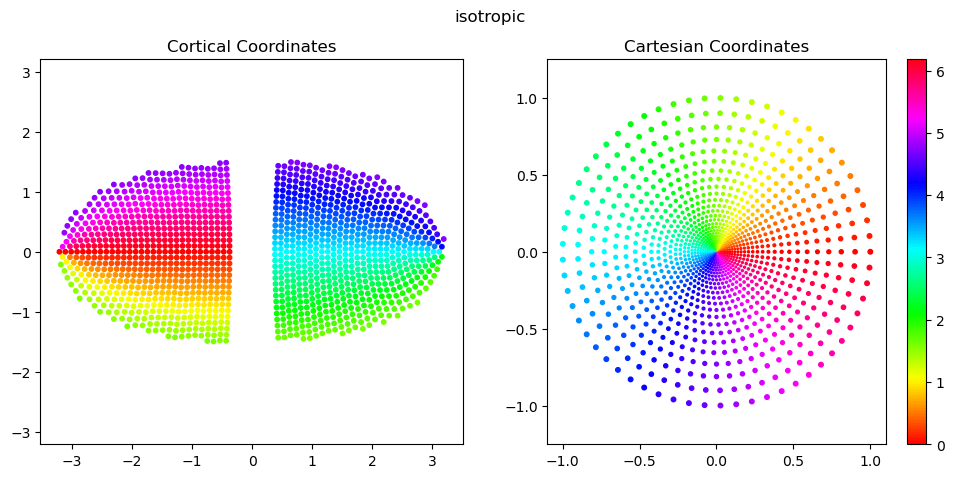

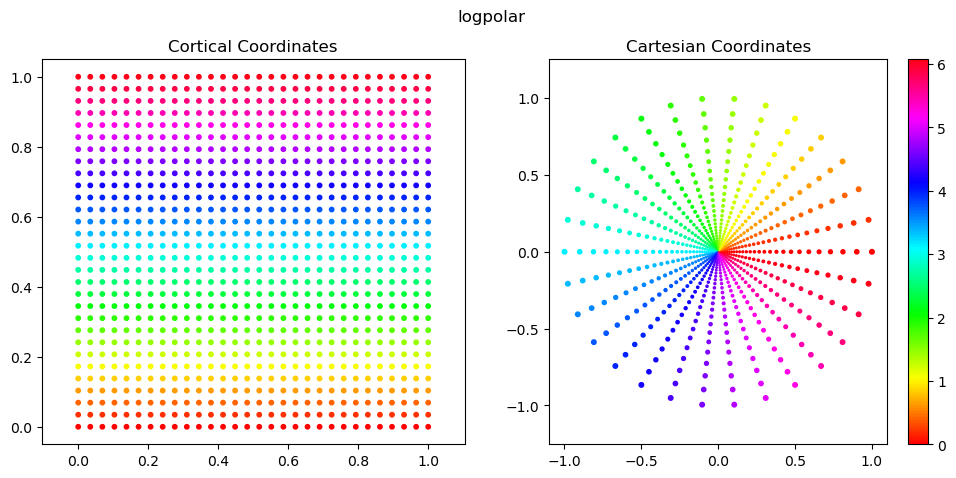

/n/home12/nblauch/.conda/envs/new_workshop/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


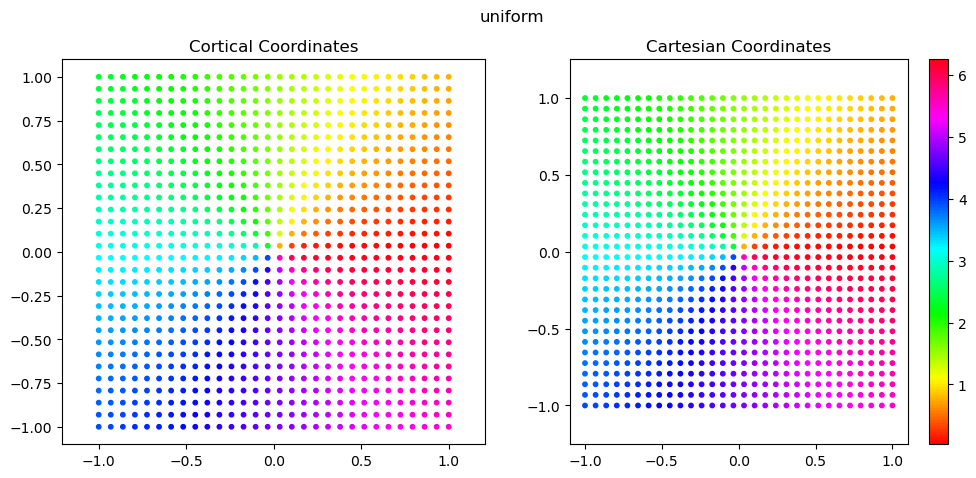

In [3]:

for fov, cmf_a, n_radii in itertools.product(
        [16], # field-of-view in degrees
        [0.5], # a parameter in CMF: M(r)=1/(r+a). smaller = stronger fovi
        [30], # number of radii to sample
    ):
    for style in ['isotropic', 'logpolar', 'uniform']: # ['conformal', 'image', 'isotropic', 'nonconformal']:
        color_by = 'angle' # 'radius' or 'angle'
        coords = SamplingCoords(fov, cmf_a, n_radii, style=style)
        sizes = 20*coords.get_scatter_sizes() if style != 'uniform' else 10

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        color = coords.polar[:,0] if color_by == 'radius' else coords.polar[:,1] %(2*np.pi) if color_by == 'angle' else coords.cartesian[:,1]
        cmap = 'hsv' if color_by == 'angle' else 'viridis'

        axs[0].scatter(coords.plotting[:,0], coords.plotting[:,1], s=10, c=color, cmap=cmap)
        axs[0].axis('equal')
        axs[0].set_title('Cortical Coordinates')

        scatter = axs[1].scatter(coords.cartesian[:,0], coords.cartesian[:,1], s=sizes, c=color, cmap=cmap)
        plt.colorbar(scatter, ax=axs[1])
        axs[1].axis('equal')
        axs[1].set_title('Cartesian Coordinates')

        # note: this is how you plot the image coordinates
        # scatter = plt.scatter(coords.cartesian_rowcol[:,1], coords.cartesian_rowcol[:,0], s=sizes, c=color, cmap=cmap)
        # plt.colorbar(scatter, ax=axs[2])
        # plt.axis('equal')
        # plt.set_title('Image Coordinates')
        # plt.set_ylim(plt.get_ylim()[::-1])

        plt.suptitle(style)
        plt.show()



## 2. Use the RetinalTransform class to perform foveated sensing

In [4]:
from fovi.sensing.retina import RetinalTransform
from fovi.demo import get_image_as_batch

ex_type = 'highres'
# ex_type = 'lowres'

if ex_type == 'highres':
    batch = get_image_as_batch('streetview.jpg', device=device)
    sampling_res = 128
    crop_area = 0.5
else:
    batch = get_image_as_batch('shark.png', device=device)
    sampling_res = 64
    crop_area = 1

orig_res = batch.shape[2] * np.sqrt(crop_area)


In [5]:
from fovi.utils import normalize

sampler = 'grid_nn'

for style in ['isotropic', 'logpolar', 'uniform']:
    retinal_transform = RetinalTransform(resolution=sampling_res, fov=16, cmf_a=0.5, start_res=orig_res, style=style, sampler=sampler, auto_match_cart_resources=True, device=device)
    coords = retinal_transform.sampler.coords
    output = retinal_transform(batch, fix_loc=[0.5,0.5]).cpu()
    output = output.reshape(output.shape[0], output.shape[1], -1)

    fig = plt.figure(figsize=(10, 4))

    # fig, axs = plt.subplots(1, 2, figsize=(16, 5), width_ratios=[1,2])
    ax1 = fig.add_subplot(121)
    ax1.scatter(coords.cartesian[:,0].cpu().numpy(), coords.cartesian[:,1].cpu().numpy(), c=normalize(output[0].T, dim=0), s=4)
    
    # ax2 = fig.add_subplot(132, projection='3d', azim=-55, elev=15)
    # scatter = ax2.scatter(coords.cortical[:,2].cpu().numpy(), coords.cortical[:,0].cpu().numpy(), coords.cortical[:,1].cpu().numpy(), s=4, c=normalize(output[0].T, dim=0), cmap='cmr.eclipse_r')
    
    ax3 = fig.add_subplot(122)
    ax3.scatter(coords.plotting[:,0].cpu().numpy(), coords.plotting[:,1].cpu().numpy(), c=normalize(output[0].T, dim=0), s=4)
    
    axs = [ax1, ax3]
    for ax in axs:
        ax.set_aspect('equal')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Pooling samplers for anti-aliasing

From here on, we'll just focus on the "isotropic" sampling approach, since this is the main foveated sampler of interest.

One issue of any foveated sensor is that the more peripheral regions can exhibit aliasing due to their sparser sampling.

We can limit this by performing an anti-aliasing option via local pooling.

Fortunately, our kNN-based operations make this very straight forward. Given a high-res and a low-res foveated sampling grid (with the same foveation parameter 
), for each unit in the low-res grid, we can pool responses over the k nearest-neighbors of the high-res grid to get an anti-aliased output. We can do a simple average pooling, or use a 2D Gaussian to weight the pooling.


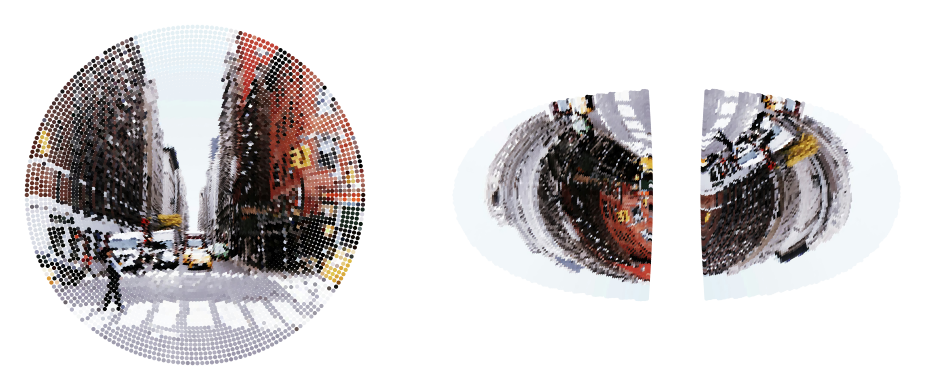

auto-set knngridsampler k=9


/n/home12/nblauch/.conda/envs/new_workshop/lib/python3.9/site-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


auto-set knngridsampler k=9


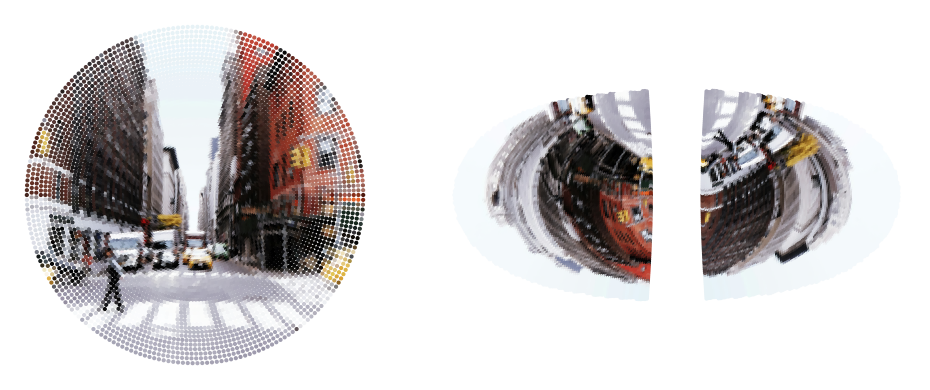

In [6]:
from fovi.utils import normalize

style = 'isotropic'
for sampler in ['grid_nn', 'pooling', 'gaussian_pooling']:
    sampler = RetinalTransform(resolution=sampling_res, fov=16, cmf_a=0.5, style=style, start_res=orig_res, sampler=sampler, auto_match_cart_resources=True, device=device)
    coords = sampler.sampler.coords
    output = sampler(batch, fix_loc=[0.5,0.5]).cpu()
    output = output.reshape(output.shape[0], output.shape[1], -1)

    fig = plt.figure(figsize=(10, 4))

    # fig, axs = plt.subplots(1, 2, figsize=(16, 5), width_ratios=[1,2])
    ax1 = fig.add_subplot(121)
    ax1.scatter(coords.cartesian[:,0].cpu().numpy(), coords.cartesian[:,1].cpu().numpy(), c=normalize(output[0].T, dim=0), s=4)
        
    ax3 = fig.add_subplot(122)
    ax3.scatter(coords.plotting[:,0].cpu().numpy(), coords.plotting[:,1].cpu().numpy(), c=normalize(output[0].T, dim=0), s=4)
    
    axs = [ax1, ax3]
    for ax in axs:
        ax.set_aspect('equal')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 3. Fixating with a SaccadePolicy

Now that we understand the basics of foveated sensing with the `RetinalTransform` class, we will demonstrate how to do a very simple form of saccading - random! 

The `MultiRandomSaccadePolicy` class is the workhorse here, but mainly just wraps functionality from its `retinal_transform` object. It will generate a set of random fixations at particular locations and particular crop sizes. We can make the crop size random or fixed. We can make the random fixating restricted to the area of the iamge that allows for fully-contained crops, or within a particular central zone of the image. 

In [7]:
from fovi.demo import get_image_as_batch

ex_type = 'highres'
# ex_type = 'lowres'

if ex_type == 'highres':
    batch = get_image_as_batch('streetview.jpg', device=device)
    sampling_res = 128
    crop_area = 0.5
else:
    batch = get_image_as_batch('shark.png', device=device)
    sampling_res = 64
    crop_area = 1

orig_res = batch.shape[2]

sampler = 'pooling'

In [8]:
from fovi.sensing.retina import RetinalTransform
from fovi.sensing.policies import MultiRandomSaccadePolicy

retinal_transform = RetinalTransform(resolution=sampling_res, start_res=orig_res, device=device, sampler=sampler)

fixator = MultiRandomSaccadePolicy(retinal_transform, n_fixations=4, norm_dist_from_center=0.25, crop_area_range=[crop_area, crop_area])

auto-set knngridsampler k=9


In [9]:
fixator_outputs = fixator(batch)

Let's inspect the fixator_outputs, which is a dictionary

In [10]:
fixator_outputs.keys()

dict_keys(['x_fixs', 'fixations', 'fixation_sizes', 'fix_deltas'])

Let:
- $f$: number of fixations
- $b$: batch size
- $c$: number of input channels (generally 3)
- $n$: number of sensor samples

Then, we have
- `fixator_outputs['x_fixs']`: the fixation outputs, stored as a ($b,f,c,n$) tensor.
- `fixator_outputs['fixations']`: fixation coordinates, stored as a ($b,f,2$) tensor, reported in [row, col] format normalized to [0,1] 
- `fixator_outputs['fixation_sizes']`: fixation sizes, stored as a ($b,f,2$) tensor, reported in pixel units in the original image 
- `fixator_outputs['fix_deltas']`: relative fixation coordinates between the current fixation and the prior, stored as a $(b, f, 2)$ tensor



## Now, let's visualize the fixations

To plot in absolute coordinates, we can make use of the `transform_sampling_grid` utility

Note, this is normally used for coordinates that are passed directly into `torch.nn.functional.grid_sample`, which annoyingly expects (col, row) coordinates a.k.a (x, -y). So we need to flip the sign of the y coordinate after the transformation into absolute coordinates.

In [11]:
fixator_outputs['x_fixs'].shape

torch.Size([1, 4, 3, 16183])

In [12]:
from fovi.sensing.coords import transform_sampling_grid
from fovi.utils import normalize

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(3*4, 4*3), gridspec_kw={'width_ratios': [1, 1, 2]})

for ii in range(fixator_outputs['x_fixs'].shape[1]):
    fix_imgs = fixator_outputs['x_fixs'][:,ii].cpu().numpy()
    fix_loc = fixator_outputs['fixations'][:,ii]
    fix_size = fixator_outputs['fixation_sizes'][:,ii]
    rel_cart_coords = retinal_transform.sampler.coords.cartesian.cpu().numpy()
    abs_cart_coords = transform_sampling_grid(retinal_transform.sampler.out_sampling_grid, fix_loc, fix_size, (orig_res, orig_res)).squeeze().cpu().numpy()
    abs_cart_coords[:,1] = -abs_cart_coords[:,1]
    manifold_coords = retinal_transform.sampler.coords.plotting.cpu().numpy()

    sizes = 10*retinal_transform.scatter_sizes
    color = normalize(fix_imgs[0].T, dim=0)

    axs[ii,0].scatter(x=rel_cart_coords[:,0], y=rel_cart_coords[:,1], c=color, s=sizes)
    axs[ii,1].scatter(x=abs_cart_coords[:,0], y=abs_cart_coords[:,1], c=color, s=sizes)
    axs[ii,2].scatter(x=manifold_coords[:,0], y=manifold_coords[:,1], c=color, s=4)

    if ii == 0:
        axs[ii,0].set_title('Relative image coordinates')
        axs[ii,1].set_title('Absolute image coordinates')
        axs[ii,2].set_title('Sensor manifold coordinates')

for ii in range(axs.shape[0]):
    for jj in range(axs.shape[1]):
        ax = axs[ii,jj]
        # ax.axis('equal')

        if jj != 2:
            ax.set_ylim(-1,1)
            ax.set_xlim(-1,1)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

# 4. Interactive fixating

For fun, we can build a little interactive fixating demo and play with it (this won't work in the docs)

In [13]:
from ipywidgets import interact, FloatSlider, IntSlider

retinal_transform = RetinalTransform(resolution=sampling_res, start_res=orig_res, fov=16, cmf_a=0.5, style='isotropic', sampler='pooling', 
                                     auto_match_cart_resources=True,
                                     device=device)

@interact(x=FloatSlider(min=0, max=1, value=0.5), y=FloatSlider(min=0, max=1, value=0.5), crop_size=FloatSlider(min=0, max=1, value=1), size_mult=IntSlider(min=0, max=50, value=10))
def fixate(x=0.5, y=0.5, crop_size=1, size_mult=10):
    size_pix = np.sqrt(crop_size)*orig_res
    sizes = size_mult*retinal_transform.scatter_sizes
    fix_loc = (1-y,x)
    output = retinal_transform(batch, fix_loc=fix_loc, fixation_size=size_pix).cpu()
    # output = output.reshape(output.shape[0], output.shape[1], -1)

    rel_cart_coords = retinal_transform.sampler.coords.cartesian.cpu().numpy()
    abs_cart_coords = transform_sampling_grid(retinal_transform.sampler.out_sampling_grid, fix_loc, (size_pix, size_pix), (orig_res, orig_res)).squeeze().cpu().numpy()
    abs_cart_coords[:,1] = -abs_cart_coords[:,1]
    manifold_coords = retinal_transform.sampler.coords.plotting.cpu().numpy()

    color = normalize(output[0].T, dim=0)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(4*3, 3), gridspec_kw={'width_ratios': [1, 1, 2]})
    axs[0].scatter(x=rel_cart_coords[:,0], y=rel_cart_coords[:,1], c=color, s=sizes)
    axs[1].scatter(x=abs_cart_coords[:,0], y=abs_cart_coords[:,1], c=color, s=sizes)
    axs[2].scatter(x=manifold_coords[:,0], y=manifold_coords[:,1], c=color, s=4)

    axs[0].set_title('Relative image coordinates')
    axs[1].set_title('Absolute image coordinates')
    axs[2].set_title('Sensor manifold coordinates')

    for jj in range(axs.shape[0]):
        ax = axs[jj]
        # ax.axis('equal')

        if jj != 2:
            ax.set_ylim(-1,1)
            ax.set_xlim(-1,1)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

auto-set knngridsampler k=9


interactive(children=(FloatSlider(value=0.5, description='x', max=1.0), FloatSlider(value=0.5, description='y'…

<Figure size 640x480 with 0 Axes>